<a href="https://colab.research.google.com/github/digs1998/Neural_Style_Transfer/blob/master/neural_style_transfer_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import important Packages

In [0]:

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch 
from torch import nn,optim
from torchvision import models,transforms


### Load pretrained VGG Model 

In [0]:
vgg_model=models.vgg19(pretrained=True).features

# Freeze the Features of VGG
for param in vgg_model.parameters():
    param.requires_grad_(False)

### Run GPU and Pass VGG to Cuda

In [56]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [0]:
def load_image(img_path,max_size=500,shape=None):
    
    image=Image.open(img_path).convert('RGB')
    
    if max(image.size)>max_size:
        size=max_size
    else:
        size=max(image.size)
    
    if shape is not None:
        size=shape
    
    in_transform=transforms.Compose([transforms.Resize(size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485,0.456,0.406),(0.299,0.224,0.225))])
    image=in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [0]:
content_image=load_image("/motoki-tonn-vV1a1Leq-dQ-unsplash.jpg").to('cuda')
style_image=load_image('/massimiliano-morosinotto-AKW2gWJC9mM-unsplash.jpg',shape=content_image.shape[-2:]).to('cuda')

In [0]:
def img_convert(tensor):
    image=tensor.to("cpu").clone().detach()
    image=image.numpy().squeeze()
    image=image.transpose(1,2,0)
    image=image*np.array((0.229,0.224,0.225))+np.array((0.485,0.456,0.406))
    image=image.clip(0,1)
    
    return image


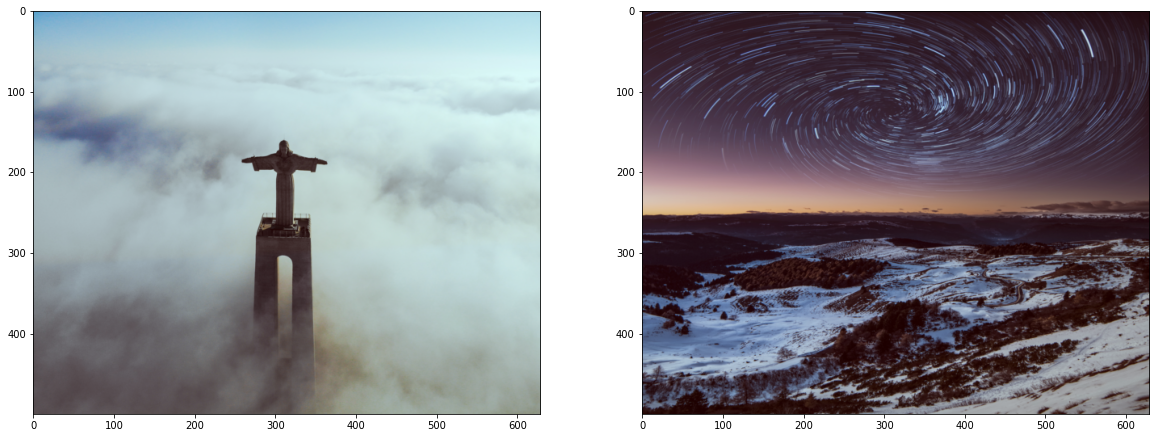

In [60]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
ax1.imshow(img_convert(content_image))
ax2.imshow(img_convert(style_image))

In [0]:
def get_features(image,model,layers=None):
    
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [0]:
def gram_matrix(tensor):
    
    _,d,h,w=tensor.size()
    
    tensor=tensor.view(d,w*h)       # Tensor *transpose Tensor 
    
    return torch.mm(tensor,tensor.t())

In [0]:
content_features=get_features(content_image,vgg_model)     #Extract Features 

style_features=get_features(style_image,vgg_model)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

target = content_image.clone().requires_grad_(True).to("cuda")


In [0]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta


Total loss:  24700462.0


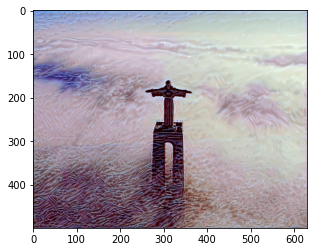

Total loss:  12980440.0


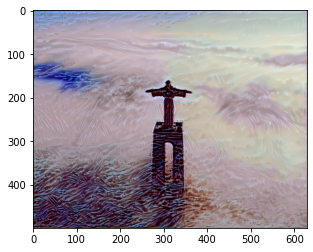

Total loss:  7997231.5


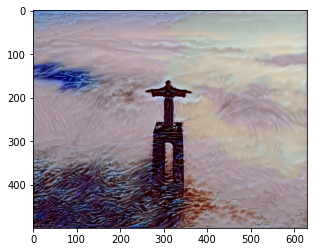

Total loss:  5288455.5


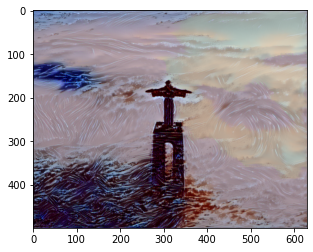

Total loss:  3574873.0


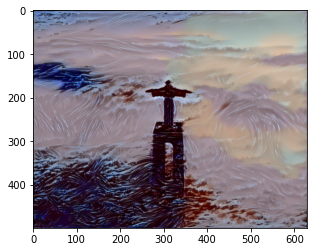

In [65]:
show_every = 1000

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 5000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg_model)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(img_convert(target))
        plt.show()

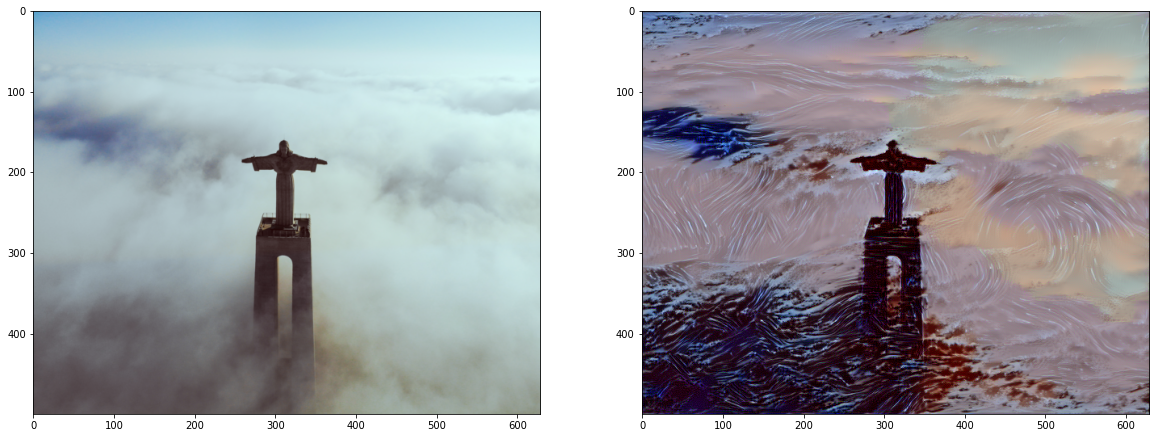

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(img_convert(content_image))
ax2.imshow(img_convert(target))